In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, Flatten, Reshape, BatchNormalization
from keras.layers import Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from keras.models import Model, Sequential
from keras.layers import ReLU
from keras.optimizers import RMSprop
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
data_path = "/Users/robert/src/MachineLearning/processed_result/merged_data.csv"
feat = ["EDA"]
sf = 4
window = 0.25

In [ ]:
class autoencoder:
    def __init__(self, **kwargs):
        self.df = pd.read_csv(data_path)
        self.batch_size = int(sf*window) 
        self.sname = self.df["Name"].unique().astype(str)
        self.K = len(self.df["Label"].unique())

    def one_hot_enc(self, r, k):
        new_r = np.zeros((r.shape[0],k))
        for i, val in enumerate(r):
            new_r[i, val-1] = 1

        return new_r
    
    def get_data(self, test_id, v_batch_size, v_feat_list, df):
        
        cnt=0
        
        for name in self.sname:
            df_s = df[df["Name"] == name]

            n = (len(df_s)//v_batch_size)*v_batch_size
            df_s = df_s[:n]
            s = StandardScaler().fit_transform(df_s[v_feat_list])
            s = s.reshape(int(s.shape[0]/v_batch_size), s.shape[1],  v_batch_size)

            lbl_m = np.zeros((s.shape[0],1))
            lbl = df_s["Label"].values.astype(int)
            for i in range(s.shape[0]):
                lbl_m[i] = int((stats.mode(lbl[i * v_batch_size : (i + 1) * v_batch_size - 1]))[0].squeeze())
            y_k = lbl_m.astype(int)
            s_y = self.one_hot_enc(lbl_m.astype(int), self.K).astype(int)
            if name==test_id:
                x_test = s
                y_test = s_y
                yk_test = y_k
            else:
                if cnt:
                    x_train = np.concatenate((x_train, s), axis=0)
                    y_train = np.concatenate((y_train, s_y), axis=0)
                    yk_train = np.concatenate((yk_train, y_k), axis=0)
                else:
                    x_train = s
                    y_train = s_y
                    yk_train = y_k
                cnt +=1


        print ("merged train:", x_train.shape, y_train.shape)
        print ("merged test :", x_test.shape, y_test.shape)
        return x_train, y_train, x_test, y_test, yk_train, yk_test
    
    def autoenc_model(self, v_batch_size, n_feat):
        input_sig = Input(shape=(n_feat, v_batch_size))
        x = Conv1D(v_batch_size,6, activation='relu', padding='same')(input_sig)
        x1 = BatchNormalization()(x)
        x2 = Conv1D(v_batch_size,3, activation='relu', padding='same')(x1)
        flat = Flatten()(x2)

        encoded = Dense(40, activation='relu')(flat)

        encoder = Model(input_sig, encoded)

        d1 = Dense(v_batch_size*n_feat)(encoded)
        d2 = Reshape((n_feat,v_batch_size))(d1)
        d3 = Conv1D(v_batch_size,3, activation='relu', padding='same')(d2)
        d4 = BatchNormalization()(d3)
        d5 = Conv1D(v_batch_size,6, activation='sigmoid', padding='same',  name='reconst_output')(d4)

        model= Model(input_sig, d5)

        return encoder, model
    
    def extract_feature(self):
        for name in self.sname:
            name = self.sname
            print("============= test subject " +name+ " ==================")
            
            x_train, y_train, x_test, y_test, yk, yk_test = self.get_data (test_id = name,
                                                                           v_batch_size=sf,
                                                                           v_feat_list=feat, 
                                                                           df=self.df)
            encoder, model = self.autoenc_model(v_batch_size=sf, n_feat=len(feat))
            model.compile(optimizer=RMSprop(learning_rate=0.00025), loss="mse")
            history = model.fit(x_train, x_train, epochs=4)

            emb_train = encoder.predict(x_train)
            emb_test = encoder.predict(x_test)

            print("emb_train", emb_train.shape)
            print("emb_test", emb_test.shape)
            
            emb_train_final = np.concatenate ((emb_train, yk), axis=1)
            emb_test_final = np.concatenate ((emb_test, yk_test), axis=1)
            print("emb_train_final", emb_train_final.shape)
            print("emb_test_final", emb_test_final.shape)

            train_feat_file = "/Users/robert/src/MachineLearning/processed_result/features/train/feat_loso"+name+".csv"
            test_feat_file = "/Users/robert/src/MachineLearning/processed_result/features/test/feat_loso"+name+".csv"
            os.makedirs(os.path.dirname(train_feat_file), exist_ok=True)
            os.makedirs(os.path.dirname(test_feat_file), exist_ok=True)
            pd.DataFrame(emb_train_final).to_csv(train_feat_file)
            pd.DataFrame(emb_test_final).to_csv(test_feat_file)



    def compare_reconstruction(self, test_id, v_batch_size, v_feat_list, df, n_examples=5):
        
        print("============= Reconstruction Comparison for test subject " + test_id + " ==================")
        # Get the data for this subject (use same split as in extract_feature)
        x_train, y_train, x_test, y_test, _, _ = self.get_data(test_id=test_id,
                                                                v_batch_size=v_batch_size,
                                                                v_feat_list=v_feat_list,
                                                                df=df)
        # Build the autoencoder model
        encoder, model = self.autoenc_model(v_batch_size=v_batch_size, n_feat=len(v_feat_list))
        model.compile(optimizer=RMSprop(learning_rate=0.00025), loss="mse")
        
        # Train the model (you can adjust epochs as needed)
        history = model.fit(x_train, x_train, epochs=4, verbose=1)
        
        # Get reconstructed signals for test data
        reconstructions = model.predict(x_test)
        
        # Plot a few examples: each x_test sample has shape (n_feat, v_batch_size)
        for i in range(min(n_examples, x_test.shape[0])):
                # Flatten the multi-dimensional signal for plotting
                original_signal = x_test[i].flatten()
                reconstructed_signal = reconstructions[i].flatten()
                
                plt.figure(figsize=(12, 4))
                plt.plot(original_signal, label='Original', linewidth=2)
                plt.plot(reconstructed_signal, label='Reconstructed', linewidth=2, alpha=0.7)
                plt.title(f"Reconstruction Comparison - Example {i+1} for Subject {test_id}")
                plt.xlabel("Time steps")
                plt.ylabel("Signal Amplitude")
                plt.legend()
                plt.show()

    

In [10]:
ae = autoencoder ()
ae.extract_feature()

============= test subject wenxin ==================
merged train: (2857166, 1, 4) (2857166, 6)
merged test : (398611, 1, 4) (398611, 6)
Epoch 1/4
89287/89287 ━━━━━━━━━━━━━━━━━━━━ 95s 1ms/step - loss: 0.5695
Epoch 2/4
89287/89287 ━━━━━━━━━━━━━━━━━━━━ 92s 1ms/step - loss: 0.5426
Epoch 3/4
89287/89287 ━━━━━━━━━━━━━━━━━━━━ 92s 1ms/step - loss: 0.5404
Epoch 4/4
89287/89287 ━━━━━━━━━━━━━━━━━━━━ 94s 1ms/step - loss: 0.5420
89287/89287 ━━━━━━━━━━━━━━━━━━━━ 36s 400us/step
12457/12457 ━━━━━━━━━━━━━━━━━━━━ 5s 422us/step
emb_train (2857166, 40)
emb_test (398611, 40)
emb_train_final (2857166, 41)
emb_test_final (398611, 41)


============= Reconstruction Comparison for test subject ted ==================
merged train: (473299, 2, 16) (473299, 5)
merged test : (79978, 2, 16) (79978, 5)
Epoch 1/4
14791/14791 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 0.5900
Epoch 2/4
14791/14791 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 0.5523
Epoch 3/4
14791/14791 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 0.5532
Epoch 4/4
14791/14791 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.5500
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step


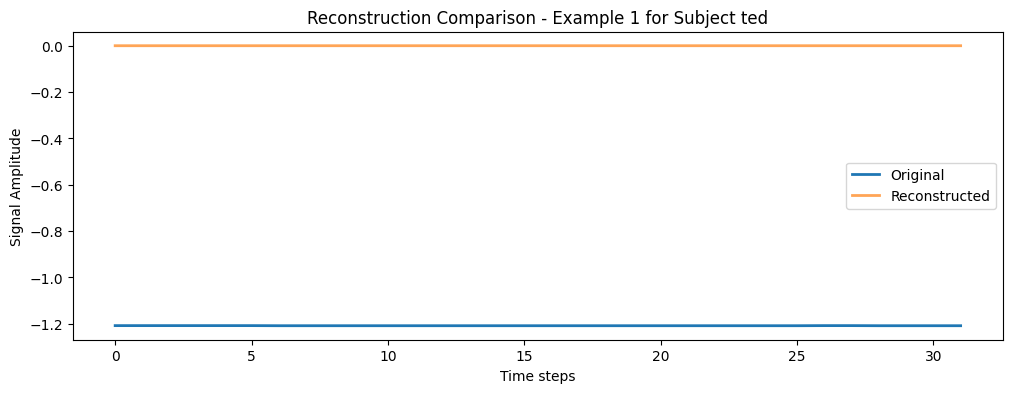

============= Reconstruction Comparison for test subject wenxin ==================
merged train: (472327, 2, 16) (472327, 5)
merged test : (80950, 2, 16) (80950, 5)
Epoch 1/4
14761/14761 ━━━━━━━━━━━━━━━━━━━━ 253s 17ms/step - loss: 0.5821
Epoch 2/4
14761/14761 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 0.5459
Epoch 3/4
14761/14761 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 0.5451
Epoch 4/4
14761/14761 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - loss: 0.5449
2530/2530 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step


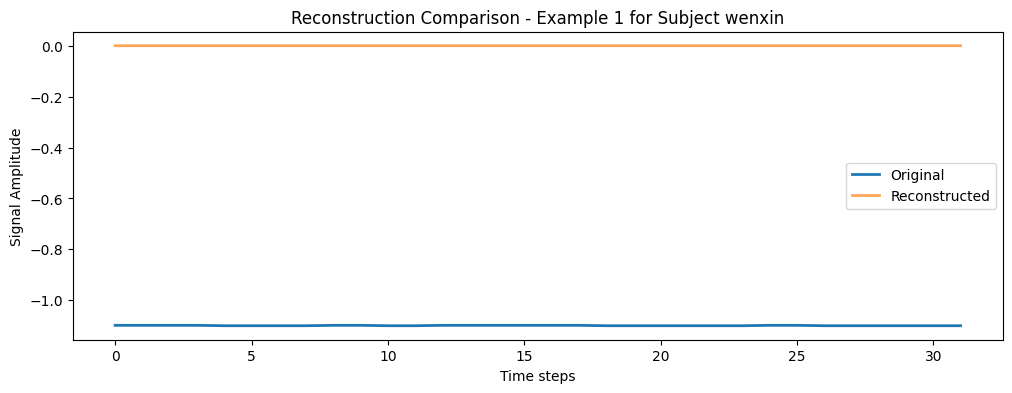

In [18]:
ae.compare_reconstruction(test_id="ted", v_batch_size=sf, v_feat_list=feat, df=ae.df, n_examples=1)
ae.compare_reconstruction(test_id="wenxin", v_batch_size=sf, v_feat_list=feat, df=ae.df, n_examples=1)

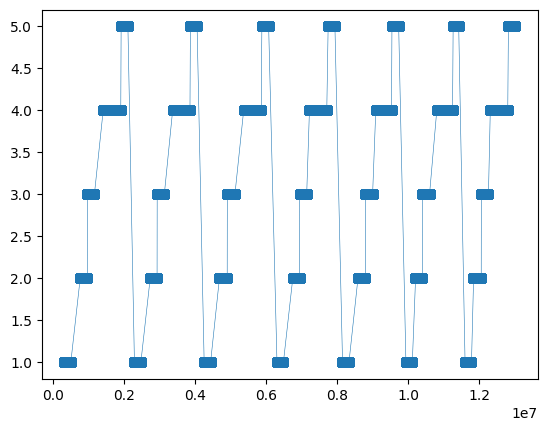

In [30]:
plt.plot(ae.df.index, ae.df['Label'], marker='s', label='Label', linewidth=0.4)